# DS/ML Training Camp: Trending Event Detection
----
By Chris, <span style="color:red">INTERNAL USE ONLY, DO NOT SHARE</span>

## Introduction

In this assignment, we will work on a real world dataset from Twitter. The ultimate goal of your job is to identify the trending event over time and find out the corresponding tweets.

During this assignment, you will need to build a machine learning pipeline to achive this goal by yourself. But don't worry, this notebook will guide you through those process step by step. To be specific, the tasks in this assignment include:
- Data Pre-processing and Exploratory Data Analysis (EDA)
- Anoamly Detection Algorithm Implementation
- Trending Event Detection using Anomaly Detection
- Retrieve tweets related to trending event


Hopefully, after this assignment you can
- Get familiar with how the time-series anomaly detection algorithm works
- Understand the introduced approach for detecting trending event using time-series anomaly detection
- Know more related Python libraries and get a better sense of how the machine learning library can boost your work.

## High-level Idea of Event Detection

To detect the trending events in our dataset, we will do the following steps:
- Firstly, we will parse the collected tweets and extract the keywords and key phrases from them.

- Secondly, for each top keyword or key phrase, we will construct a time-series (daily) based on its number of appearance in the twitter stream.

- Next, we will apply the anomaly detection algorithm against the timeseries of each keyword or key phrase, and mark the dates when that keyword or key phrase is identified as *anomaly*.

- Finally, we group the keywords and key phrases together by the dates when they are detected as *anomaly*. 

Therefore, for each date, by combing all the keywords and key phrases that are anomalous in terms of number of appearances, we can have an idea of what topics are trending on that date.

## Dataset

Let's first get familiar with the datasets, this time we have processed the raw text data for you, so you can focus more on the model and algorithm side.


You should find a folder called dataset and our data is organized by date in it (from **2020-03-22** to **2020-08-22**), within each subfolder, you should be able to find following files:

|Filename|Description|
|---|---|
|DATE_top1000bigrams.csv | Top 1000 bi-grams ordered by counts from the tweets |
|DATE_top1000terms.csv   | Top 1000 terms ordered by counts from the tweets |
|DATE_top1000trigrams.csv| Top 1000 tri-grams ordered by counts from the tweets  |



#### Now, open the each file and have a look, then move to the next section

### Environment Setup

Please use Python3.6+ for this assignment, and you should have following Python library installed:
- numpy
- scipy
- statsmodels
- NLTK
- matplotlib

In [2]:
# you can use pip to install the package here
#!pip3 install -U pip # this is to update your pip if needed
!pip3 install nltk

     |████████████████████████████████| 1.4 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 284 kB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 141 kB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434676 sha256=9f9dee0c1361909395ea58f31e2ff7723045464111942d574a7a758586407052
  Stored in directory: /Users/yangzhengjie/Library/Caches/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built nltk
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline
from typing import List, Dict, Optional
from datetime import date, timedelta
from collections import Counter, defaultdict

import json
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1108)>


False

In [6]:
# download the stopwords package from NLTK


import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')





[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangzhengjie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Get the stopwords list from NLTK
stop_words = set(stopwords.words('english'))

Have a look on what stopwords are provided by NLTK,

In [8]:
print(len(stop_words))

179


In [9]:
# TODO (optional): You can always come back add any custom stopwords 
#                  here to improve the quality of final results
custom_stopwords = ['nan',]

In [10]:
stop_words.update(custom_stopwords)

## Data Pre-processing and Exploratory Data Analysis (EDA)

In this first task, we will need to build the time-series for the key words and key phrases in tweets. For simplicity, we will use the term token to represent either terms or bigrams or trigrams in our dataset.

- We have tweet token counts from 2020-03-22 to 2020-08-22, let's pick top 500 eligible tokens based on all time high counts (e.g., if a token appears in multiple days, we use the highest count as its all time high count) as our selected tokens in each of these 3 files.
- For the selected tokens from each of the 3 files, we build daily time-series from 2020-03-22 to 2020-08-22 (the value will be the number of appearance on each date given in the file), so you will have 1500 time-series after the data pre-processing.

Here are the requirements for eligible token:
- Token should be converted the token to lower case.
- Eligible token should at least have 3 letters.
- Eligible token should consist of alphabet characters or numbers, but not only numbers (you can use the Python3 string `.isalnum()` and `.isdigit()` functions)
- Eligible token should not be stopwords (you can filter them out using the defined `stop_words` set)

In [11]:
# Start date and end date of the datasets, DO NOT CHANGE
start_dt = date(2020,3,22)
end_dt = date(2020,8,22)

In [12]:
# This counter is used to figure out each token's highest count (i.e., all time high count)
terms_counter = Counter()

# Use this dict to remember the count of each token in each daydaily_counts[]
# usage: daily_counts[date_string][token_string], e.g. daily_counts['2020-04-01']['covid19']
daily_counts = defaultdict(dict)

# Use this dict to remember the mininum count among all token in each day
# this dict is used to fill the missing value if one token does not appear in some other date
daily_min_counts = {}

In [15]:
dt = start_dt
while dt <= end_dt:
    daily_min_counts[dt] = float('inf')
    # iterating through entire datasets
    with open(f'./dataset/{dt.isoformat()}/{dt.isoformat()}_top1000terms.csv', 'r') as f:
        for line in f.readlines():
            token, count = line.strip().split(',')
            count = int(count)
            
            # TODO: check the eligibility here
            # 1. token should be converted the token to lower case.
            # 2. token should at least have 3 letters.
            # 3. token should consist of alphabet characters or numbers, but not only numbers
            # 4. token should not be stopwords
            if ((len(token)>2) and (token not in stop_words) and (token.isalnum()) and (token.isdigit() == False)):
                term = token.strip().lower()  
            
            # TODO: Fill the terms_counter, daily_counts and daily_min_couts
            dt_str = dt.isoformat()
            if term:
                terms_counter[term] = max(terms_counter[term],count)
                daily_counts[dt][term] = count
                daily_min_counts[dt] = min(daily_min_counts[dt],count)
            
            
    dt += timedelta(days=1)

In [16]:
print(f'Number of eligible tokens: {len(terms_counter)}')
print(f'Top N tokens with counts:\n{terms_counter.most_common(5)}')

Number of eligible tokens: 4114
Top N tokens with counts:
[('coronavirus', 365236), ('covid', 255660), ('covid19', 248841), ('trump', 75936), ('cases', 60019)]


In [17]:
# TODO (optional): You can decide how many tokens you want to use, default is 1000
topN = 1000

In [18]:
# Use Counter.most_common(N) function to select topN eligible tokens
selected_tokens = [x for x, _ in terms_counter.most_common(topN)]

In [19]:
selected_tokens[:100]

['coronavirus',
 'covid',
 'covid19',
 'trump',
 'cases',
 'people',
 'amp',
 'new',
 'vaccine',
 'via',
 'pandemic',
 'polmascegahcovid19',
 'siagalawancovid19',
 'bolsonaro',
 'deaths',
 'lockdown',
 'china',
 'dalam',
 'dan',
 'virus',
 'realdonaldtrump',
 'news',
 'russia',
 'partisipasicegahcovid19',
 'putin',
 'may',
 'vacuna',
 'health',
 'data',
 'like',
 'get',
 'one',
 'stay',
 'world',
 'disinfectant',
 'positive',
 'masyarakat',
 'first',
 'rally',
 'testing',
 'covidー19',
 'home',
 'florida',
 'crisis',
 'help',
 'easter',
 'support',
 'time',
 'mask',
 'cain',
 'casos',
 'baksospolripeduli',
 'pemerintah',
 'death',
 'penyebaran',
 'ayoikutiaturan',
 'day',
 'work',
 'twitter',
 'would',
 'herman',
 'yang',
 'president',
 'need',
 'know',
 'doctors',
 'video',
 'tulsa',
 'masks',
 'workers',
 'adalah',
 'polri',
 'membantu',
 'oxford',
 'cdc',
 'memerangi',
 'covid2019',
 'untuk',
 'hydroxychloroquine',
 'cummings',
 'jiwakemanusiaanpolri',
 'could',
 'government',
 'toda

Good job, now you have got all the tokens, let's then build the timeseries for all of them

In [77]:

# This timeseries variable is used to store all the tokens and their timeseries in key, value format,
# so that you can easily find a token's timeseries by querying the `timeseires` dict
timeseries = defaultdict(list)

# Since all the timeseries should have same timetamps range, we put them into this `ts_idx` list
ts_idx = []

In [78]:
dt = start_dt
while dt <= end_dt:
    dt_str = dt.isoformat()
    ts_idx.append(dt_str)
    for token in selected_tokens:
        # TODO: construct the timeseries using `daily_counts`
        #       if a token does not have count for that date,
        #       use that day's minimum count minus 1 to fill it
        if daily_counts[dt].get(token) is not None:
            timeseries[token].append(daily_counts[dt][token])
        else:
            timeseries[token].append(daily_min_counts[dt]-1)
            
    dt += timedelta(days=1)

In [79]:
# Have a look at ts_idx to make sure you know its format
print(ts_idx[:10])
print(len(ts_idx))

['2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31']
154


In [25]:
# Have a look of raw time-series for token `covid`
print(timeseries['covid'])

[64625, 64625, 81299, 87927, 84130, 86337, 88211, 85666, 86045, 84245, 81883, 87801, 84289, 84508, 88115, 147042, 88191, 86294, 86159, 177003, 165238, 149204, 87796, 87441, 87872, 84300, 87832, 188075, 162115, 87533, 202177, 215341, 244463, 85161, 184007, 176959, 191668, 78109, 83345, 82026, 232681, 160025, 181829, 193076, 218040, 226726, 72617, 243692, 237600, 221695, 62944, 72995, 231589, 214502, 235946, 235463, 203197, 183314, 59663, 198124, 193825, 233720, 229764, 184729, 176203, 204385, 233083, 240133, 213401, 213041, 175263, 165413, 191270, 208844, 213502, 205036, 198248, 160974, 152674, 201153, 204190, 203239, 217747, 195240, 149118, 141077, 199463, 210100, 210021, 203584, 211505, 171033, 145184, 195486, 206215, 192321, 206427, 195015, 169706, 153927, 200065, 203613, 203746, 196797, 192116, 150395, 166085, 214526, 238524, 220280, 223908, 203045, 141182, 162408, 218255, 227139, 211307, 227539, 217091, 149659, 157923, 219258, 220434, 208357, 219940, 204673, 141289, 137167, 204648,

We have defined the following visualization functions to help show the trend of token over the given time range, now let's can do some visualization, please check the trends for token `covid`, `vaccine` and `death`, you may also pick some other tokens that you may like to their trends

In [26]:
def plot_ts(ts: List[float], labels: List[str] = None) -> None:
    if not labels:
        labels = list(range(len(ts)))
    plt.plot(labels, ts)
    plt.grid()
    plt.xlabel('date')
    plt.ylabel('# of appearance')
    plt.show()

def token_trend(token: str):
    plot_ts(timeseries[token])

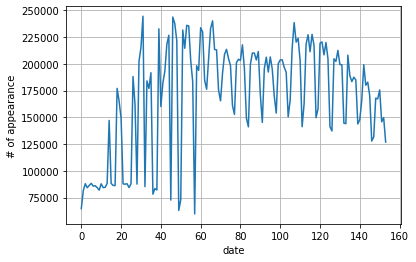

In [89]:
token_trend('covid')

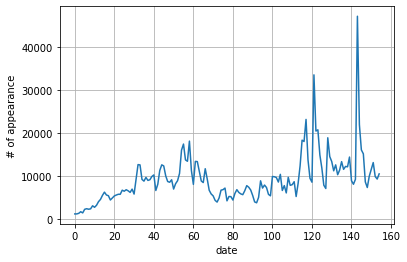

In [28]:
token_trend('vaccine')

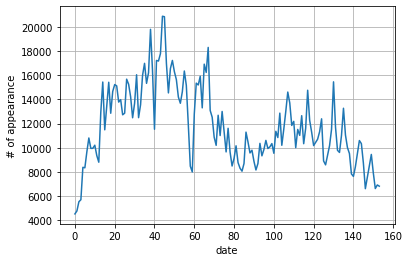

In [29]:
token_trend('death')

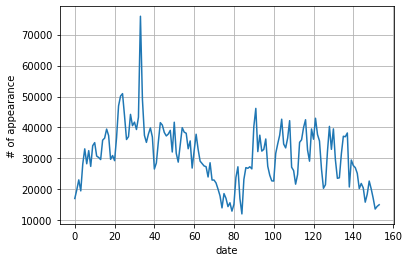

In [90]:
# TODO (optional): Feel free to pick any other token that you many want to check its trend as well
token_trend('trump')

Did you find any data point that you believe should be an anomaly? If so, that's great! We will start to work on the Anomaly Detection algorithm in the next part.

## Anoamly Detection Algorithm Implementation

In this part, we will implement the anomaly detection algorithm mentioned in this paper: [Automatic Anomaly Detection in the Cloud Via Statistical Learning](https://arxiv.org/pdf/1704.07706.pdf), we also attached a pdf copy just in case you cannot download it from the source.

This paper introduced a few popular anomaly detection algorithms from Twitter (we also talked through them during the class) and they are also widely used in industries. For our project, we will implement the **Seasonal Hybrid ESD (Extreme Studentized Deviate)** algorithm mentioned in the paper.


Please read through the paper to help you have an in-depth understanding of how the Seasonal Hybrid ESD algorithm works. Actually, this algorithm also got explained in our video course, free feel to go back and have a second look if that's helpful.

Final words: reading scientific paper and bring the key ideas into your model is also a killer skill for cool Data Scientist!

### Seasonal Trend Decomposition

In [32]:
!pip3 install statsmodels

     |████████████████████████████████| 9.6 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 31.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [33]:
import numpy as np
import statsmodels.api as sm
from statsmodels.robust.scale import mad
from scipy.stats import t as student_t

To help you start, we have implement the STL function for you, this function help you decompose the time-series into 3 different components (i.e., seasonal, trend and residual)

In [34]:
def stl(series: np.ndarray, period: int):
    """
    Seasonal-Trend decomposition
    series : numpy.array
        Time-series in ndarry
    periood : int
        Period of the seasonal component.
        For example, if the  time series is monthly with a yearly cycle, then
        freq=12.
    """
    decomp = sm.tsa.seasonal_decompose(series, period=period)
    return decomp.seasonal, decomp.trend, decomp.resid

For example, we can use the STL function to decompose the time-sereis for token: 'covid'

In [35]:
seasonal, trend, resid = stl(np.array(timeseries['covid']), period=7)

Original Timeseries


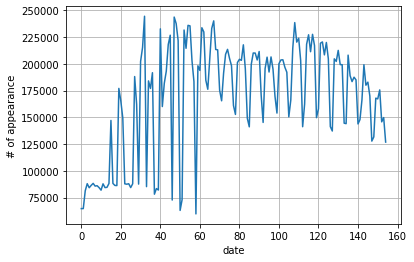

Seasonal Component


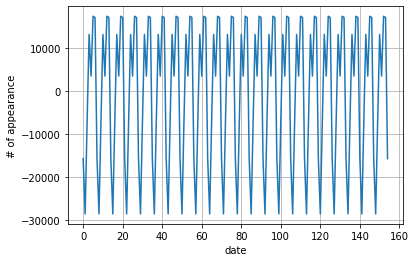

Trend Component


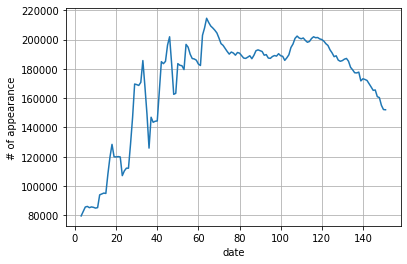

Residual Component


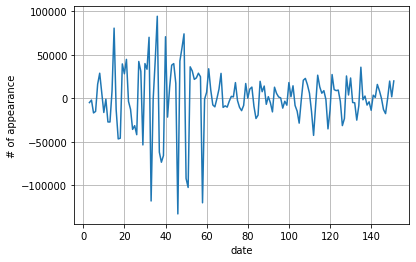

In [36]:
print('Original Timeseries')
plot_ts(timeseries['covid'])
print('Seasonal Component')
plot_ts(seasonal)
print('Trend Component')
plot_ts(trend)
print('Residual Component')
plot_ts(resid)

### Robust Extreme Studentized Deviate (ESD) Test Algorithm

#### Test statistics
In Robust ESD test, we first define the maximum number of anomalies $K$, and then compute the following test statistic for the $k=1,2,...,K$ most extreme values in the data set:

$$
C_k=\frac{\max_k |x_k-\tilde{x}|}{\hat{\sigma}}
$$

where $\tilde{x}$ is the median of the series and $\hat{\sigma}$ is the median absolute deviation (MAD), which is defined as $\text{MAD} = \text{median}(|X-\text{median}(X)|)$.

Tips: to calcuate MAD, you can use the mad function from statsmodels (i.e., `from statsmodels.robust.scale import mad`)

#### Critical value
The test statistic is then used to compare with a critical value, which is computed using following equation:

$$
\lambda_k=\frac{(n-k) t_{p,\ n-k-1}}{\sqrt{(n-k-1+t_{p,\ n-k-1}^2)(n-k+1)}}
$$

Note here to compute the $t_{p,\ n-k-1}$ in critical value, you can use following code

```python
from scipy.stats import t as student_t
p = 1 - alpha / (2 * (N - k + 1))
t = student_t.ppf(p, N - k - 1)
```
#### Anomaly direction
The another thing we need to do is to determine the direction or the anomaly (i.e., the anomaly is going up or going down), this information is useful because in some anomaly detection task we may only care anomaly goes to only one direction (e.g., for the error count or error rate, we only care if it increases a lot).

To determine the direction of anomaly, we can use the sign of the $|x_k-\tilde{x}|$ in $C_k$. If sign is positive, then the anomaly is greater than median and it's very likely to be a spike, otherwise, it should be a dip.

We have provided the skeleton of `robust_seasonal_esd_test` function to help you get started, following the TODO to complete the function. Also, feel free to modify the logic and build your own.

In [61]:
from scipy.stats import t as student_t
from statsmodels.robust.scale import mad
import statsmodels
import math

In [82]:
def robust_seasonal_esd_test(ts, max_anom=5, seasonal=False, period=None, alpha=0.05, threshold=1.0):
    """Robust Seasonal Extreme Studentized Deviate Test"""
    series = np.copy(ts)
    
    N = len(series)
    ts_index = np.array(range(N))
    
    if len(ts) != len(ts_index):
        print(f"Bad timeseries, length={len(ts)}")
        return []
    
    # TODO: Implement the seasonal decomposition as an option
    if seasonal:
        if not period:
            raise RuntimeError("Period must be set if the time series is seasonal")
        # TODO: remove the seasonal signal and median (based on the paper)
        seasonal, trend, resid = stl(series, period=7)
        series = resid
        
    anom_list = []
    n_anom = 0
    
    x_mad = statsmodels.robust.scale.mad(series)
    x_median = np.median(series)
    
    
    for k in range(1, max_anom+1):
        
        # TODO: Compute the test statistic C_k
        C_k = np.max(abs(series-x_median)/x_mad) 
        max_idx = np.argmax(abs(series-x_median))
        
        
        # TODO: determine the direction or anomaly
        if (series[max_idx]-x_median) >= 0:
            direction = 'up'
        else:
            direction = 'down'
        
        # TODO: Compute the critical value
        p = 1 - alpha / (2 * (N - k + 1))
        t = student_t.ppf(p, N - k - 1)
        denom = math.sqrt((N - k - 1 + t ** 2)*(N - k + 1))
        lambda_k = (N - k) * t / denom

        # The score is defined as C_k / lambda_k, if the score > threshold,
        # we take this data point as an anomaly
        score = C_k / lambda_k
        if score > threshold:
            n_anom = k
        else:
            break
        
        anom_list.append({
            "rank": k,
            "index": int(ts_index[max_idx]),
            "value": float(ts[ts_index[max_idx]]),
            "direction": direction,
            "score": round(score, 2)
        })
            
        # Remove the identified value from both time-series and index
        series = np.delete(series, max_idx)
        ts_index = np.delete(ts_index, max_idx)
    return anom_list

Not sure whether your implementation is correct? You can try it with some real timeseries.

Here we have provided another visualization function to help you inspect your results and a pretty_print function to print dict/list in a more readable way. Read the docstring of the function to understand what you need to provide as input.

In [66]:
def plot_anomaly_on_ts(ts: List[float], anom_index_list: List[int], anom_value_list: List[int]) -> None:
    """
    Plot timeseries chart together with detected anomalies as scatter points
    ts:
        The values of timeseries
    
    anom_index_list:
        The list of timeseries index for the detected anomalies, for instance, if the 2nd data point
        is identified as anomaly, the index will be 1 (since it starts from 0)
    
    anom_value_list:
        The list of values for the detected anomalies
    """
    labels = list(range(len(ts)))
    plt.plot(labels, ts)
    plt.scatter(anom_index_list, anom_value_list, s=50.0, c='red')
    plt.grid()
    plt.xlabel('date')
    plt.ylabel('# of appearance')
    plt.show()

def pretty_print(struct):
    """
    struct:
        The struct can be anything that is JSON serializable, like dictionary, or list.
    """
    print(json.dumps(struct, indent=2))

[
  {
    "rank": 1,
    "index": 142,
    "value": 47077.0,
    "direction": "up",
    "score": 2.76
  },
  {
    "rank": 2,
    "index": 120,
    "value": 33480.0,
    "direction": "up",
    "score": 1.79
  },
  {
    "rank": 3,
    "index": 116,
    "value": 23138.0,
    "direction": "up",
    "score": 1.05
  }
]


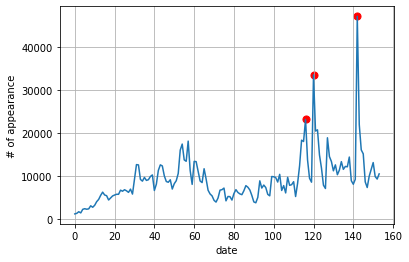

In [83]:
ts = np.array(timeseries['vaccine'])
anom_list = robust_seasonal_esd_test(ts, threshold=1.0)
pretty_print(anom_list)
anom_index = []
anom_value = []

# TODO: for our use case, you should only keep anomalies going up
for anom_dic in anom_list:
    anom_index.append(anom_dic["index"])
    anom_value.append(anom_dic["value"])

plot_anomaly_on_ts(ts, anom_index, anom_value)

If you use the timeseries for token **vaccine**, you implementation should detec the 3 obvious anomalies at index  116, 120 and 142 (see the screenshot below). If not, please double check your implementation.
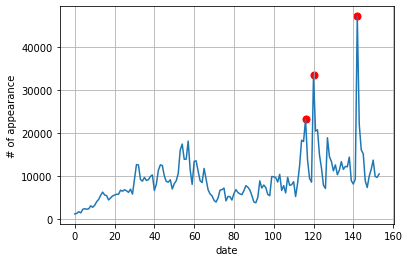

If you believe your implementation is good, congrats! You can move to the next part!

## Trending Event Detection using Anomaly Detection

In this part, we will apply the anomaly detection algorithm we have implemented to timeseries of all the token we have obtained in the data preprocessiing step. By connecting anomaly index with actual dates, this will give us each token's "anomaly dates".

If we group tokens by their "anomaly dates", we will know the trending keywords in each date!

In [80]:
# Recall you have already had the timeseries index: ts_idx
print(f'length={len(ts_idx)}')
print(ts_idx[:5])

length=154
['2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26']


### Apply Anomaly Detection and Group Keywords

Now let's apply the anomaly detection algorithm you have built for the timeseries of all keywords!

In [81]:
# We will use this dict to remember the anomalous token for each date
# format: daily_anom_tokens[date_string][anomalous_token] = anom_dict_from_the_algorithm
daily_anom_tokens = defaultdict(dict)

In [85]:
all_tokens = timeseries.keys()

for token in all_tokens:
    # TODO: apply anomaly detection for the timeseries of all tokens.
    #       Notice we only want anomaly with direction going "Up"
    
    ts = np.array(timeseries[token])
    anom_list = robust_seasonal_esd_test(ts, threshold=1.0)
    for anom_dic in anom_list:
        daily_anom_tokens[anom_dic["index"]][token] = anom_dic
    
    

Great! Let's see what you can find from them

In [91]:
# In this part you need to print out the trending keywrods (i.e., the anomalous tokens)
# you identified for each date

for date in sorted(daily_anom_tokens.keys()):
    key_tokens = daily_anom_tokens[date].keys()
    # TODO:
    #   1. add the score for its token to create (token, score) tuple
    #   2. sort the token for each date by score (descending)
    ordered_tokens = []
    for key_token in key_tokens:
        ordered_tokens.append((key_token,daily_anom_tokens[date][key_token]["score"]))
        
    ordered_tokens.sort(key = lambda x: x[1], reverse=True)
    
    # Here we print the token along with its score in descending order
    
    print(date)
    for token, score in ordered_tokens:
        space = ' '*(27-len(token))
        print(f'{token}{space}{score}')
    print()

0
italian                    4.77
italy                      4.1
colleagues                 3.72
stand                      3.26
coronaviruspandemic        3.25
stayathome                 1.65
friends                    1.62
recovered                  1.54
fallecidos                 1.26
reported                   1.25
nuevos                     1.08
muertes                    1.05
pandemic                   1.02
salud                      1.02

1
italy                      2.35
senate                     1.8
italian                    1.69
recovered                  1.49
democrats                  1.49
fallecidos                 1.2
reported                   1.19
colleagues                 1.1
stand                      1.09
muertes                    1.03
nuevos                     1.0

2
hantavirus                 4.06
recovered                  1.46
self                       1.19
fallecidos                 1.17
reported                   1.13
muertes                    1.01

3
ch

kebijakan                  4.89
menjalankan                4.78
internationalnursesday     4.13
bersama                    4.03
obama                      3.81
obamagate                  3.15
rantai                     2.91
senate                     2.85
safe                       2.48
dan                        2.4
package                    2.32
memutus                    2.07
trillion                   1.92
fauci                      1.88
atau                       1.88
society                    1.81
akan                       1.66
narendramodi               1.44
stay                       1.42
democrats                  1.15

52
mudik                      17.58
stopmudikcegahcovid19      16.14
polri                      10.31
tidak                      5.62
mata                       5.35
rantai                     5.17
penyebaran                 5.09
memutus                    5.01
hari                       4.78
saat                       4.58
guna                       4.19
at

drug                       3.72
fda                        1.62
life                       1.21
rise                       1.0

87
dexamethasone              7.2
beijing                    5.88
steroid                    1.58
wave                       1.56
arizona                    1.51
positivo                   1.09
friends                    1.09

88
arizona                    1.88
apple                      1.45
dexamethasone              1.05

89
rally                      6.07
tulsa                      4.21
apple                      2.9
players                    2.54
alert                      2.46
level                      2.39
día                        1.21

90
rally                      16.78
tulsa                      14.24
staffers                   6.68
campaign                   6.18
six                        5.39
covidiots                  2.92
ahead                      2.42
brazil                     2.18
players                    1.67
positive                 

### Event Detection

Now you should have the trending keywords for each date! Below you can find a list of real trending events ordered by dates, you can review the trending keywords and see if you can find some signal from them for the same date.

#### Real Events
- Mar 24, 2020 [People are worrying about the hantavirus](https://www.deseret.com/u-s-world/2020/3/24/21192254/coronavirus-covid-19-hantavirus-china-india-nyc-global-times-prevention-symptoms)
- Mar 27, 2020 [Coronavirus strikes UK Prime Minister Boris Johnson](https://www.cnn.com/2020/03/27/uk/uk-boris-johnson-coronavirus-gbr-intl/index.html)
- April 7, 2020 [World Health Day](https://www.who.int/campaigns/world-health-day/world-health-day-2020)
- April 29, 2020 [NIH clinical trial shows Remdesivir accelerates recovery from advanced COVID-19](https://www.nih.gov/news-events/news-releases/nih-clinical-trial-shows-remdesivir-accelerates-recovery-advanced-covid-19)
- May 11, 2020 [What is 'Obamagate' and why is Trump so worked up about it?](https://www.theguardian.com/us-news/2020/may/12/what-is-obamagate-and-why-is-trump-so-worked-up-about-it)
- May 29, 2020 [Monkey steals COVID-19 blood samples from a lab technician in India](https://www.livescience.com/monkey-steals-covid-19-blood-samples.html)
- June 4, 2020 [5 things to know for June 4: George Floyd, protests, coronavirus, stimulus, oil spill](https://www.cnn.com/2020/06/04/us/five-things-june-4-trnd/index.html)
- June 13, 2020 [Beijing closes market, locks down area in new virus outbreak](https://medicalxpress.com/news/2020-06-beijing-area-virus-outbreak.html)
- ...
- July 20, 2020 [Coronavirus vaccine from Oxford and AstraZeneca shows positive response in early trial](https://www.cnbc.com/2020/07/20/oxford-universitys-coronavirus-vaccine-shows-positive-immune-response-in-an-early-trial.html)
- July 30, 2020 [Herman Cain, Former C.E.O. and Presidential Candidate, Dies at 74](https://www.nytimes.com/2020/07/30/us/politics/herman-cain-dead.html)
- August 11, 2020 [Putin claims Russia has registered the world’s first coronavirus vaccine, says his daughter has taken it](https://www.cnbc.com/2020/08/11/russia-claims-to-have-registered-first-coronavirus-vaccine.html)

Tips: whenever you are not sure about the results, always plot the trend

Let's use World Health Day as an example

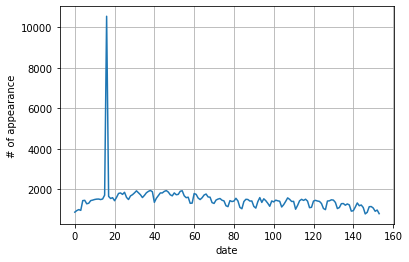

In [92]:
token_trend('worldhealthday')

#### Additional events and how to verify

If you find something interesting and not in the above list, you can verify that through Google or Twitter by searching the terms over their platforms.

#### How to determine the impact of the events

In addition, since the score from anomaly detection algorithm can only reflect the significance level of the *change*, you may also want to review the trends of all the tokens, you can use the data volume in trend to determine the impact of that event. If the event is too small, you probably cannot find it on Google.

## Additional Exploration [Optional]

Hope you have understanded our idea for trending events detection using anomaly detection, if you are interested and want to do more, below are something you can explore:
- We have tried to apply the anomaly detection to keywords throughout the entire notebook, you can extend the work and add the key phrases
- We have guided you through implementing the S-H-ESD algorithm for anomaly detection, feel free to implement something else we have discussed in the class

Hope you had enjoyed this project and had fun! Gook luck!